<a href="https://colab.research.google.com/github/Codedestructor56/DataScienceAndML/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.__version__

'1.12.1+cu113'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from torchvision import datasets, transforms
rel_trans=transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip()])
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=rel_trans)
mnist_testset=datasets.FashionMNIST(root='./data',train=False,download=True,transform=rel_trans)

In [ ]:
len(mnist_testset)

10000

In [ ]:
len(mnist_trainset)

60000

In [ ]:
from torch.utils.data import DataLoader
trainloader=DataLoader(mnist_trainset,batch_size=128,shuffle=True)
testloader=DataLoader(mnist_testset,batch_size=128,shuffle=True)


torch.Size([128, 1, 28, 28])


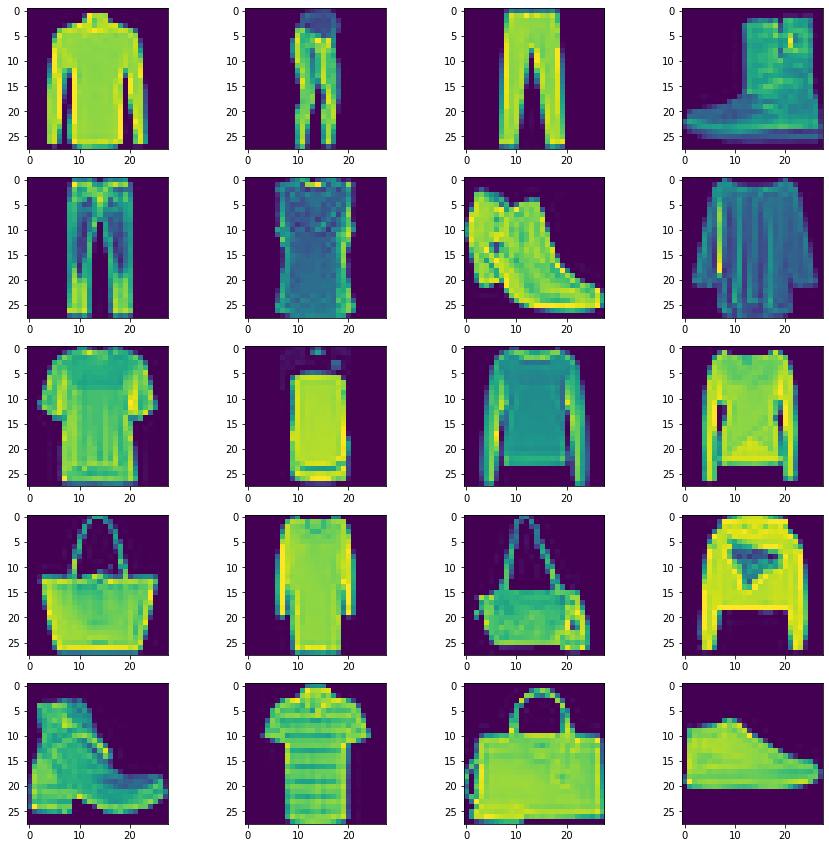

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
trainloader=iter(trainloader)
testloader=iter(testloader)
images1,labels1=testloader.next()
images,labels=trainloader.next()
print(images.shape)
fig=plt.figure(figsize=(15,15))
for i in range(20):
  ax=fig.add_subplot(5,20/5,i+1)
  ax.imshow(torch.squeeze(images[i]))
  


In [ ]:
import numpy as np
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms
another_transform=transforms.Compose([transforms.Lambda(lambda t: (t*2)-1)])
train_batch=another_transform(images)
test_batch=another_transform(images1)

Calculating all the values for forward march:

In [ ]:
T = 300
betas = torch.linspace(0.0001, 0.02, T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)#cumprod=alpha_1*alpha_2*.....*alpha_n
alphas_cumprod_prev = torch.nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


defining the forward march and adding noise to the images

In [ ]:
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = torch.gather(vals,-1,t.to('cpu'))
  
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
def actual_forward_march(tensor_shape,x_0,t=1):
  noise= torch.randn(tensor_shape)
  sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape)
  return sqrt_alphas_cumprod_t*x_0+sqrt_one_minus_alphas_cumprod_t*noise,noise

Testing the function defined above

torch.Size([1, 28, 28])

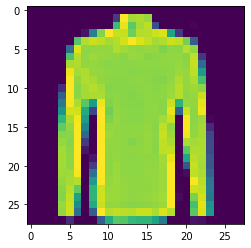

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
def image_test(sample):
  new_transform=transforms.Compose([transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), 
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()])
  if len(sample.shape) == 4:
        image = sample[0, :, :, :] 
  plt.imshow(new_transform(image))
  return image

new_img=image_test(train_batch)
new_img.shape

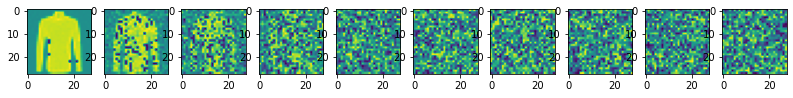

In [ ]:
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)
    image, noise = actual_forward_march(images.shape,images, t)
    image_test(image)

To take care of the time steps, we'll positionally encode every image in the batch

In [ ]:
from torch import nn
import math
class Positions(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim=dim
  def forward(self,time):
    device='cpu'
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings



Now, we will create a U-Net, the crux of this project.

In [17]:
import torch.nn as nn
def double_conv1(in_c,out_c,time_emb_dim):
    conv_layer=nn.Sequential(
      nn.Conv2d(in_c,out_c,kernel_size=3,padding=1),
      nn.BatchNorm2d(out_c),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c,out_c,kernel_size=3,padding=1),
      nn.BatchNorm2d(out_c),
      nn.ReLU(inplace=True),
    
  )
    return conv_layer
class encoder(nn.Module):
  def __init__(self,in_c,out_c,time_emb_dim):
    super().__init__()
    self.conv=double_conv1(in_c,out_c,time_emb_dim)
    self.maxpool= nn.MaxPool2d(kernel_size=2)
    
  def forward(self,image):
    x=self.conv(image)
    p=self.maxpool(x)
    return x,p
class decoder(nn.Module):
  def __init__(self,in_c,out_c,time_emb_dim):
    super().__init__()
    self.convtrans=nn.ConvTranspose2d(in_c,out_c,kernel_size=2,stride=2,padding=0)
    self.conv=double_conv1(2*out_c,out_c,time_emb_dim)
  def forward(self,image,skip):
    new_im=self.convtrans(image)
    print(image.shape)
    print(skip.shape)
    x=torch.cat([new_im,skip],axis=1)
    x=self.conv(x)
    return x


class actual_thing(nn.Module):
  def __init__(self):
    super().__init__()
    channels=(1,64,128,256)
    time_emb_dim=32
    up_channels=(512,256,128,64,1)
    self.time_mlp = nn.Sequential(
                Positions(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU())
    self.downs = nn.ModuleList([encoder(channels[i], channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(channels)-1)])
    self.conv_block=double_conv1(256,512,time_emb_dim)
    self.ups = nn.ModuleList([decoder(up_channels[i], up_channels[i+1], \
                                        time_emb_dim) \
                    for i in range(len(up_channels)-1)])
    
    self.conv1=nn.Conv2d(64,1,kernel_size=1,padding=0)
  def forward(self,image,timestep):
    return nn.Sequential(self.time_mlp,self.downs,self.conv_block,self.ups,self.conv1)

new_image=torch.rand([1,1,32,32])
model=actual_thing()
print(model(new_image,24))

Sequential(
  (0): Sequential(
    (0): Positions()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (1): ModuleList(
    (0): encoder(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): encoder(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=

loss func

In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = actual_forward_march(x_0.shape, x_0, t)
    noise_pred = model(x_noisy, t)
    return torch.nn.l1_loss(noise, noise_pred)

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 28
    img = torch.randn((1, 1, img_size, img_size), device='cpu')
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device='cpu', dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            plt.figure(figsize=(15,15))
            plt.axis('off')
            num_images = 10
            stepsize = int(T/num_images)
            image_test(img.detach().cpu())
    plt.show()            

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 500

for epoch in range(epochs):
    for step, batch in enumerate(new_img):
      optimizer.zero_grad()

      t = torch.randint(0, T, (28,), device=device).long()
      loss = get_loss(model, batch.unsqueeze[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()